# This is a baseline, Do not run, it will not execute properly

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # add import

from torchvision import transforms, datasets
from torchvision.transforms import InterpolationMode
from torchvision.transforms import v2 as T

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from ShroomDataset import ShroomDataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, top_k_accuracy_score

import numpy as np
import matplotlib.pyplot as plt

import time
import pandas as pd
from PIL import Image, ImageOps
import os
from tqdm.auto import tqdm

data_path = './data/'

train_meta = pd.read_csv(os.path.join(data_path, 'train.csv'))#.iloc[:1000]
val_meta = pd.read_csv(os.path.join(data_path, 'val.csv'))
test_meta = pd.read_csv(os.path.join(data_path, 'test.csv'))

# val_meta = train_meta
# test_meta = train_meta


In [2]:
# class ShroomDataset(Dataset):

#     def __init__(self, df, base_path = './data/', transform = None, label2idx = None):
#         self.df = df
#         self.base_path = base_path
#         self.transform = transform

#         if label2idx is None:
#             unique = sorted(self.df['label'].unique())
#             self.label2idx = {label : idx for idx, label in enumerate(unique)}
#         else:
#             self.label2idx = label2idx

#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, index):
        
#         row  =  self.df.iloc[index]

#         img_path = self.base_path + row['image_path']
#         img = Image.open(img_path)
#         img = ImageOps.exif_transpose(img)       # handle camera rotation
#         if img.mode != 'RGB':                    # <- key line
#             img = img.convert('RGB')

#         if self.transform:
#             img = self.transform(img)
        
#         label = self.label2idx[row['label']]

#         return img, label
    



In [ ]:

IMG_SIZE = 224 # im doing the same size as imageNET cause why not

mean = (0.485, 0.456, 0.406)  # these are just imagenet stats,
# but i should get the actual dataset stats, for this version it doesnt really matter
# cause this is just a CNN, no pretraining, so idc
std  = (0.229, 0.224, 0.225)


# make the transforms for training and validation
# we want the train images to be really hard to classify and when we give 
# the model the validation images, they should be easier to classify, so will lead to less overfitting?
train_tf = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0), ratio=(0.8, 1.25), antialias=True),
    T.RandomHorizontalFlip(0.5),
    T.RandomApply([T.ColorJitter(0.15,0.15,0.15,0.05)], p=0.3),
    T.RandomApply([T.RandomRotation(10)], p=0.25),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])

val_tf = T.Compose([
    T.Resize(IMG_SIZE, antialias=True),
    T.CenterCrop(IMG_SIZE),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])

# make dataset opjects with the transforms
train_ds = ShroomDataset(train_meta, data_path, transform=train_tf)
val_ds   = ShroomDataset(val_meta,   data_path, transform=val_tf, label2idx=train_ds.label2idx)
test_ds  = ShroomDataset(test_meta,  data_path, transform=val_tf, label2idx=train_ds.label2idx)

# calculate weights for the sampler
num_classes = len(train_ds.label2idx)
train_labels = np.asarray(train_ds.labels, dtype=np.int64)
idx2label = {v: k for k,v in train_ds.label2idx.items()}
# frequency-based weights (inverse freq)
counts = np.bincount(train_labels, minlength=num_classes)
alpha = 0.5  # try 0.3–0.7
class_w = (np.maximum(counts, 1) ** -alpha)
sample_w = class_w[train_labels]

# draw 100k samples per epoch with replacement
samples_per_epoch = 200_000
sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_w),
                                num_samples=samples_per_epoch,
                                replacement=True)




print(f"# classes: {num_classes}")

# this part it very machine dependent, 
# there are some reduncencies cause i was switching from MPS to CUDA to MPS frequently
BATCH = 64
NUM_WORKERS = 6

train_loader = DataLoader(
    train_ds, batch_size=BATCH, sampler=sampler,
    num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=False, prefetch_factor=4
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH, shuffle=False,
    num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=False, prefetch_factor=4
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH, shuffle=False,
    num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=False, prefetch_factor=4
)


# classes: 169


In [ ]:

# class SEBlock(nn.Module):
#     """Squeeze-and-Excitation block using 1×1 convolutions for efficiency."""
#     def __init__(self, channels, reduction=16):
#         super().__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Conv2d(channels, channels // reduction, 1, bias=False),
#             nn.GELU(),
#             nn.Conv2d(channels // reduction, channels, 1, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         # Squeeze: global spatial info
#         y = self.avg_pool(x)
#         # Excitation & scale
#         y = self.fc(y)
#         return x * y


# class CBAM(nn.Module):
#     """Convolutional Block Attention Module (CBAM) with streamlined operations."""
#     def __init__(self, channels, reduction=16, kernel_size=5):
#         super().__init__()
#         # Channel attention
#         self.channel_attn = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(channels, channels // reduction, 1, bias=False),
#             nn.BatchNorm2d(channels // reduction),
#             nn.GELU(),
#             nn.Dropout(0.2),
#             nn.Conv2d(channels // reduction, channels, 1, bias=False),
#             nn.Sigmoid()
#         )
#         # Spatial attention
#         self.spatial_attn = nn.Sequential(
#             nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         # Channel attention: refine channel weights
#         ca = self.channel_attn(x)
#         x = x * ca

#         # Spatial attention: refine spatial focus
#         max_pool, _ = x.max(dim=1, keepdim=True)
#         avg_pool = x.mean(dim=1, keepdim=True)
#         sa = self.spatial_attn(torch.cat([max_pool, avg_pool], dim=1))
#         return x * sa


# class ResidualBlock(nn.Module):
#     def __init__(self, channels, use_se=False, reduction=16):
#         super().__init__()
#         self.use_se = use_se
#         self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
#         self.bn1   = nn.BatchNorm2d(channels)
#         self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
#         self.bn2   = nn.BatchNorm2d(channels)
#         if use_se:
#             self.se = SEBlock(channels, reduction)
#         self.act = nn.GELU()
#     def forward(self, x):
#         out = self.act(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         if self.use_se:
#             out = self.se(out)
#         return self.act(x + out)



# class ConvAttnBlock(nn.Module):
#     """
#     Modular conv block:
#       1) Conv → BN → GELU
#       2) Optional CBAM attention
#       3) Optional ResidualBlock (with SE)
#     """
#     def __init__(self, in_channels, out_channels,
#                  use_cbam=False, use_res=False, use_se=False):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.GELU(),
#             nn.Dropout(0.3)
#         )
#         self.attn = CBAM(out_channels) if use_cbam else nn.Identity()
#         self.res  = ResidualBlock(out_channels, use_se=use_se) if use_res else nn.Identity()

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.attn(x)
#         x = self.res(x)
#         return x


# class ShroomCNNAttentive(nn.Module):
#     def __init__(self, in_ch=3, block_cfgs=None,
#                  mlp_units=(512,), num_classes=162):
#         super().__init__()
        
#         self.stem = nn.Sequential(
#             nn.Conv2d(in_ch, 32, kernel_size=3, stride=2, padding=1, bias=False),  # down to 192×192
#             nn.BatchNorm2d(32),
#             nn.GELU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.GELU(),
#         )
#         layers, ch = [], in_ch
#         ch = 64
#         for out_ch, do_pool, cbam, res, se in block_cfgs:
#             layers.append(ConvAttnBlock(ch, out_ch,
#                                        use_cbam=cbam,
#                                        use_res=res,
#                                        use_se=se))
#             if do_pool:
#                 # stride-2 conv instead of MaxPool for more capacity
#                 layers.append(nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=2, padding=1, bias=False))
#                 layers.append(nn.BatchNorm2d(out_ch))
#                 layers.append(nn.GELU())
#             ch = out_ch
#         self.model       = nn.Sequential(*layers)
#         self.global_pool = nn.AdaptiveAvgPool2d(1)

#         # classifier
#         mlp = []
#         in_feat = ch
#         for u in mlp_units:
#             mlp += [nn.Linear(in_feat, u),
#                     nn.BatchNorm1d(u),
#                     nn.GELU(),
#                     nn.Dropout(0.4)]
#             in_feat = u
#         mlp.append(nn.Linear(in_feat, num_classes))
#         self.classifier = nn.Sequential(*mlp)

#         self.apply(self._init_weights)
#         self.name = 'Attentive CNN'
    
#     @staticmethod
#     def _init_weights(m):
#         if isinstance(m, (nn.Conv2d, nn.Linear)):
#             nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
#             if getattr(m, 'bias', None) is not None: nn.init.zeros_(m.bias)
#         if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
#             nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
#     def forward(self, x):
#         x = self.stem(x)
#         x = self.model(x)
#         x = self.global_pool(x).view(x.size(0), -1)
#         return self.classifier(x)
    
from ShroomCNN import ShroomCNNAttentive

blocks = [
    (64,   True,  False, True,  True),   # SE only
    (128,  True,  False, True,  True),
    (256,  True,  True,  True,  True),   # CBAM only here
    (320,  True,  False, True,  True),
]
# add more models to compare here
models = { 'attentive': ShroomCNNAttentive(in_ch=3, block_cfgs=blocks,
                    mlp_units=[1024, 512], num_classes=num_classes)}

In [ ]:

class SAM(torch.optim.Optimizer):
    """
    Sharpness-Aware Minimization (SAM) optimizer wrapper.
    Wraps any base optimizer (e.g. SGD or AdamW) to perform the two-step SAM update.
    """

    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        """
        params         : iterable of parameters to optimize
        base_optimizer : torch.optim.Optimizer class (not instance), e.g. torch.optim.SGD
        rho            : SAM neighborhood size
        kwargs         : arguments for the base optimizer (lr, momentum, weight_decay, etc.)
        """
        assert rho >= 0.0, "rho must be non-negative"
        defaults = dict(rho=rho, **kwargs)
        super().__init__(params, defaults)
        # instantiate your base optimizer with the same param groups
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def first_step(self, zero_grad=True):
        """
        1) Ascent step: move to the worst‐case neighbor w + ε
        """
        # 1a) Compute the L2 norm of all gradients
        grad_norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2)
                for group in self.param_groups for p in group['params']
                if p.grad is not None
            ]),
            p=2
        )
        scale = self.param_groups[0]['rho'] / (grad_norm + 1e-12)

        # 1b) Perturb each parameter by ε = scale * grad
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)                  # w = w + ε
                self.state[p]['eps'] = e_w   # store ε for the second step

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=True):
        """
        2) Descent step: take an optimizer step from the perturbed weights,
           then restore w ← w + ε − ε = the new w.
        """
        # 2a) descent on the perturbed weights
        self.base_optimizer.step()

        # 2b) subtract ε to return to the updated original weights
        for group in self.param_groups:
            for p in group['params']:
                eps = self.state[p].get('eps')
                if eps is None:
                    continue
                p.sub_(eps)

        if zero_grad:
            self.zero_grad()

    def step(self, closure=None):
        """
        We don’t use this—call first_step() and second_step() explicitly.
        """
        raise NotImplementedError("Use first_step() and second_step() instead")

In [6]:
def mixup_batch(x, y, alpha=0.2):
    if alpha <= 0: return x, y, 1.0, y
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_m, y_a, lam, y_b

def train(model,
          train_loader,
          val_loader,
          epochs: int = 50,
          lr: float = 1e-3,
          weight_decay: float = 5e-4):
    """
    Train `model` with SAM, logging per-epoch loss & accuracy.
    Returns: (train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist)
    """
    # 1) Device setup
    device = 'mps' if torch.backends.mps.is_available() else \
             'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"[Training] using device = {device}")
    model.to(device)
    best_loss = float('inf'); best_sd = None

    # 2) Loss, optimizer, scheduler
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )


    scheduler = ReduceLROnPlateau(
        optimizer,   # <- important with SAM
        mode='min',
        factor=0.1,                 # LR *= 0.5  (try 0.2–0.5)
        patience=3,                 # epochs with no val improvement before reducing
        threshold=1e-3,             # “min improvement” to count as progress
        cooldown=0,
        min_lr=1e-6
    )

    # 3) History buffers
    train_loss_hist, train_acc_hist = [], []
    val_loss_hist,   val_acc_hist   = [], []

    # 4) Epoch loop
    for epoch in range(1, epochs+1):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        i = 0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            X, y_a, lam, y_b = mixup_batch(X, y, alpha=0.2)
            logits = model(X)
            loss   = lam * loss_fn(logits, y_a) + (1 - lam) * loss_fn(logits, y_b)
            loss.backward()

            running_loss += loss.item() * y.size(0)
            running_correct += (logits.argmax(1) == y).sum().item()
            running_total   += y.size(0)

            optimizer.step()

            
            # print(f"Epoch {epoch}: loss={running_loss/running_total:.4f}, "
            #     f"acc={running_correct/running_total:.4f}")


        epoch_loss = running_loss / running_total
        epoch_acc  = running_correct / running_total
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc)

        # ---- validation ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for Xv, yv in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
                Xv, yv = Xv.to(device), yv.to(device)
                out = model(Xv)
                val_loss += loss_fn(out, yv).item() * yv.size(0)
                val_correct += (out.argmax(dim=1) == yv).sum().item()
                val_total   += yv.size(0)

        val_loss /= val_total
        scheduler.step(val_loss)
        val_acc   = val_correct / val_total

        if val_loss < best_loss - 1e-4:
            best_loss = val_loss
            best_sd = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        curr_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch:3d}/{epochs:3d} | "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"LR: {curr_lr:.6g}")
        
 
    if best_sd is not None:
        model.load_state_dict(best_sd)
    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

In [7]:
def train_models(models, train_loader, val_loader, epochs = 20, lr = 0.001):

    ''' trains a dictionary of models with the given params'''
    
    model_history = {}
    for model in models.values():
        start_time = time.time()
        print('######################################################')
        print(f'###         TRAINING MODEL: {model.name}          ###')
        print('######################################################')

        history = train(model,
                train_loader,
                val_loader,
                epochs=epochs,
                lr=lr)
        
        model_history[model.name] = history

        print('######################################################')
        print(f'##         TIME TO TRAIN MODEL:{model.name}       ###')
        print(f'###     {(time.time() - start_time)/60} MINUTES   ###')
        print('######################################################')

    return model_history

        


In [8]:
def evaluate_models(models, test_loader, classes = idx2label.values()):

    ''' evaluate the models on never seen test data'''

    for model in models.values():
        print('######################################################')
        print(f'###         EVALUATING MODEL: {model.name}          ###')
        print('######################################################')
        
        # set device
        device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
        model.to(device)
        model.eval()

        # collect predictions and true labels to calculate metrics
        y_true = []
        y_pred = []
        y_logits = []

        with torch.no_grad():
            # load data
            for X, y in test_loader:
                # to gpu
                X = X.to(device)
                y = y.to(device)

                # make predictions
                logits = model(X)

                # get most confident
                preds = logits.argmax(dim=1)

                y_logits.append(logits.cpu())
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(y.cpu().numpy())

        # convert stacked logits
        y_logits = torch.cat(y_logits).numpy()

        # top-k accuracy
        top1_acc = accuracy_score(y_true, y_pred)
        top5_acc = top_k_accuracy_score(y_true, y_logits, k=5, labels=list(range(len(classes))))  # labels=class range

        # other classification metrics from sklearn
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')

        print(f"\nTest Accuracy (Top-1): {top1_acc:.4f}")
        print(f"Top-5 Accuracy: {top5_acc:.4f}")
        print(f"F1 Score (weighted): {f1:.4f}")
        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")

        # per-class performance
        print("\nPer-Class Report:")
        cl_report = classification_report(y_true, y_pred, target_names=classes)
        print(cl_report)
    return (top1_acc, top5_acc, f1, precision, recall, cl_report)

In [9]:
def compare_models(models, train_loader, val_loader, test_loader, epochs=50, lr=0.001, class_names=None):

    # train all models
    model_history = train_models(models, train_loader, val_loader, epochs=epochs, lr=lr)

    # evaluate all models
    eval_results = {}
    for name, model in models.items():
        print("\n\n")
        results = evaluate_models({name: model}, test_loader, classes=class_names)
        eval_results[name] = results

    # plot training curves
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    for model_name, history in model_history.items():
        train_loss, train_acc, val_loss, val_acc = history
        axs[0].plot(train_loss, label=f'{model_name} - Train' )
        axs[0].plot(val_loss, label=f'{model_name} - Val',marker='o', markersize=4 )
        axs[1].plot(train_acc, label=f'{model_name} - Train')
        axs[1].plot(val_acc, label=f'{model_name} - Val', marker='o', markersize=4)

    axs[0].set_title('Loss Curves')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].set_title('Accuracy Curves')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # return eval results and training history for data logging
    return model_history, eval_results

######################################################
###         TRAINING MODEL: Attentive CNN          ###
######################################################
[Training] using device = mps


Epoch 1/25:   0%|          | 0/3125 [00:22<?, ?it/s]

Epoch 1/25:   0%|          | 0/244 [00:08<?, ?it/s]

Epoch   1/ 25 | Train Loss: 4.6910, Train Acc: 0.0313 | Val Loss: 4.0140, Val Acc: 0.1395 | LR: 0.001


Epoch 2/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   2/ 25 | Train Loss: 3.8637, Train Acc: 0.1153 | Val Loss: 3.0822, Val Acc: 0.3471 | LR: 0.001


Epoch 3/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   3/ 25 | Train Loss: 3.2641, Train Acc: 0.2023 | Val Loss: 2.5237, Val Acc: 0.5012 | LR: 0.001


Epoch 4/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   4/ 25 | Train Loss: 2.8896, Train Acc: 0.2573 | Val Loss: 2.2775, Val Acc: 0.5697 | LR: 0.001


Epoch 5/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   5/ 25 | Train Loss: 2.6007, Train Acc: 0.3053 | Val Loss: 2.1724, Val Acc: 0.5939 | LR: 0.001


Epoch 6/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   6/ 25 | Train Loss: 2.4282, Train Acc: 0.3327 | Val Loss: 2.0350, Val Acc: 0.6384 | LR: 0.001


Epoch 7/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   7/ 25 | Train Loss: 2.2698, Train Acc: 0.3640 | Val Loss: 2.0239, Val Acc: 0.6524 | LR: 0.001


Epoch 8/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   8/ 25 | Train Loss: 2.1897, Train Acc: 0.3777 | Val Loss: 1.9152, Val Acc: 0.6783 | LR: 0.001


Epoch 9/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch   9/ 25 | Train Loss: 2.0944, Train Acc: 0.4013 | Val Loss: 1.8393, Val Acc: 0.7019 | LR: 0.001


Epoch 10/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  10/ 25 | Train Loss: 2.0367, Train Acc: 0.4129 | Val Loss: 1.8592, Val Acc: 0.7094 | LR: 0.001


Epoch 11/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  11/ 25 | Train Loss: 1.9784, Train Acc: 0.4257 | Val Loss: 1.7731, Val Acc: 0.7172 | LR: 0.001


Epoch 12/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  12/ 25 | Train Loss: 1.9425, Train Acc: 0.4239 | Val Loss: 1.7648, Val Acc: 0.7298 | LR: 0.001


Epoch 13/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  13/ 25 | Train Loss: 1.9116, Train Acc: 0.4297 | Val Loss: 1.7541, Val Acc: 0.7282 | LR: 0.001


Epoch 14/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  14/ 25 | Train Loss: 1.8648, Train Acc: 0.4462 | Val Loss: 1.7402, Val Acc: 0.7426 | LR: 0.001


Epoch 15/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  15/ 25 | Train Loss: 1.8605, Train Acc: 0.4578 | Val Loss: 1.7243, Val Acc: 0.7356 | LR: 0.001


Epoch 16/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  16/ 25 | Train Loss: 1.8279, Train Acc: 0.4435 | Val Loss: 1.7293, Val Acc: 0.7494 | LR: 0.001


Epoch 17/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  17/ 25 | Train Loss: 1.7924, Train Acc: 0.4552 | Val Loss: 1.6995, Val Acc: 0.7474 | LR: 0.001


Epoch 18/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  18/ 25 | Train Loss: 1.8010, Train Acc: 0.4650 | Val Loss: 1.6800, Val Acc: 0.7572 | LR: 0.001


Epoch 19/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  19/ 25 | Train Loss: 1.7742, Train Acc: 0.4547 | Val Loss: 1.7357, Val Acc: 0.7604 | LR: 0.001


Epoch 20/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  20/ 25 | Train Loss: 1.7753, Train Acc: 0.4431 | Val Loss: 1.6967, Val Acc: 0.7549 | LR: 0.001


Epoch 21/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  21/ 25 | Train Loss: 1.7455, Train Acc: 0.4642 | Val Loss: 1.7027, Val Acc: 0.7580 | LR: 0.001


Epoch 22/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  22/ 25 | Train Loss: 1.7586, Train Acc: 0.4642 | Val Loss: 1.6915, Val Acc: 0.7528 | LR: 0.0001


Epoch 23/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  23/ 25 | Train Loss: 1.6681, Train Acc: 0.4750 | Val Loss: 1.5664, Val Acc: 0.7936 | LR: 0.0001


Epoch 24/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  24/ 25 | Train Loss: 1.6630, Train Acc: 0.4821 | Val Loss: 1.5571, Val Acc: 0.7960 | LR: 0.0001


Epoch 25/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch  25/ 25 | Train Loss: 1.6285, Train Acc: 0.4782 | Val Loss: 1.6246, Val Acc: 0.7926 | LR: 0.0001
######################################################
##         TIME TO TRAIN MODEL:Attentive CNN       ###
###     658.7660345196724 MINUTES   ###
######################################################



######################################################
###         EVALUATING MODEL: Attentive CNN          ###
######################################################

Test Accuracy (Top-1): 0.7904
Top-5 Accuracy: 0.9445
F1 Score (weighted): 0.7924
Precision (weighted): 0.8000
Recall (weighted): 0.7904

Per-Class Report:
                             precision    recall  f1-score   support

          Agaricus augustus       0.82      0.65      0.73        51
      Agaricus xanthodermus       0.66      0.46      0.54        46
     Amanita amerirubescens       0.50      0.48      0.49        50
            Amanita augusta       0.87      0.66      0.75        50
        Amanita brun

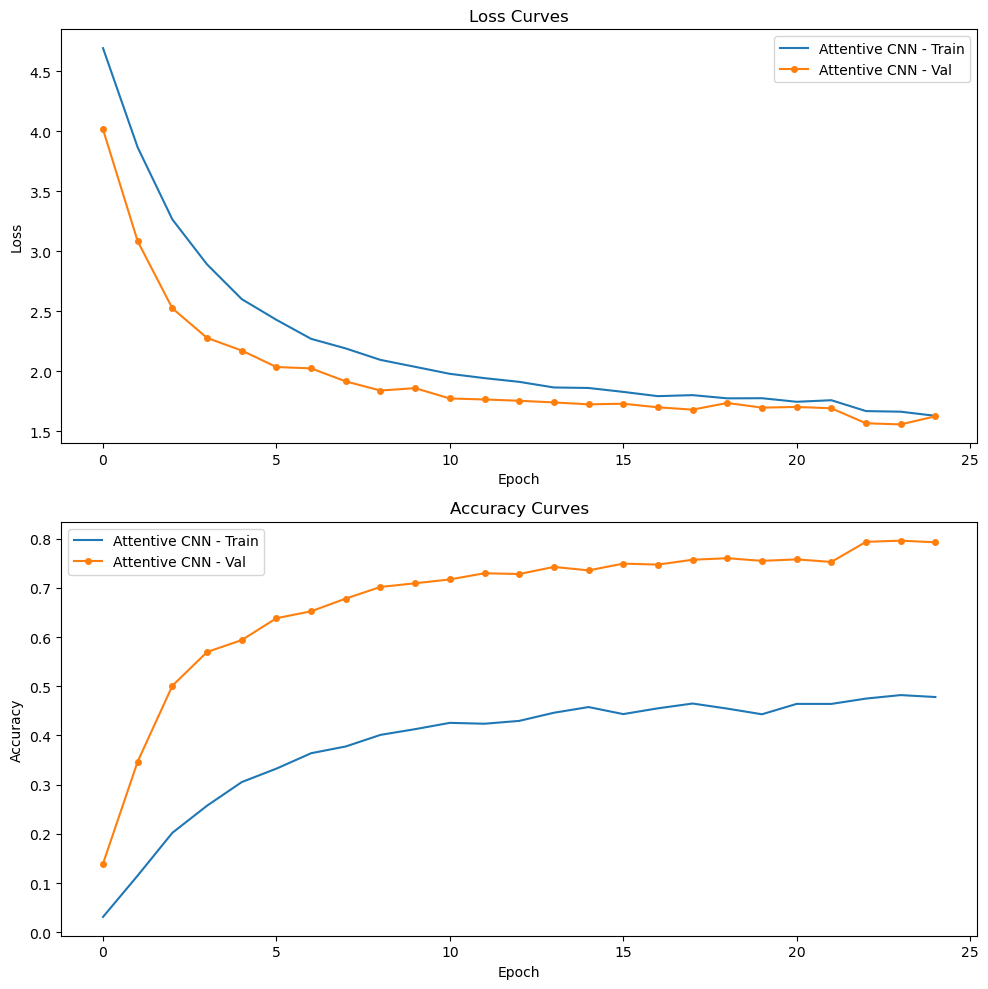

In [10]:
num_epochs = 25
lr = 1e-3
classes = [idx2label[i] for i in range(num_classes)]

model_history, eval_results = compare_models(models, train_loader, val_loader, test_loader,
                                             epochs=num_epochs, lr=lr, class_names=classes)